In [1]:
import sys
sys.path.insert(0, '../src')

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from concepts import concept_instances
from sk_probing import train_binary, train_non_binary
from utils import load_game_data, load_q_network_device

In [3]:
max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5
layer = 5

In [4]:
game_data = load_game_data()

ball y: 0.44354673419185764


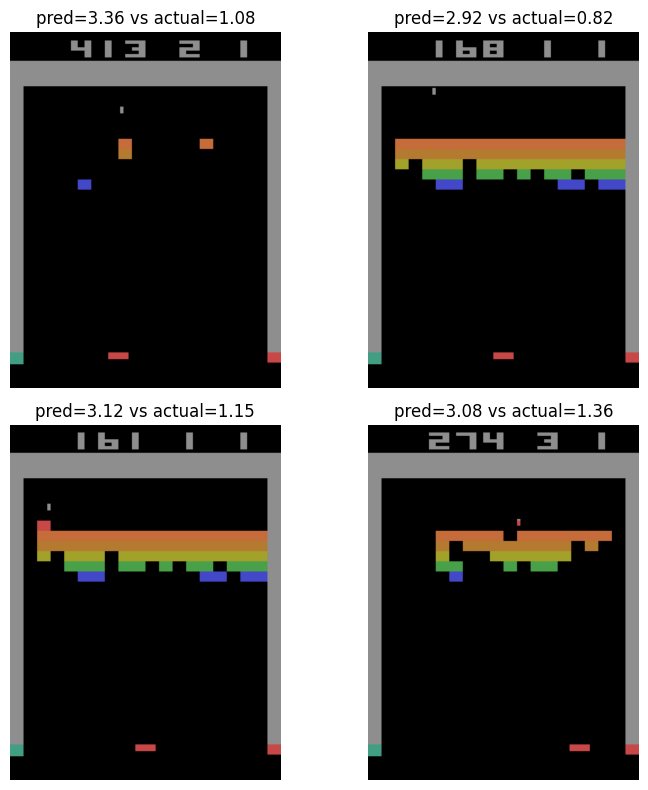

ball x: 0.854782633497983


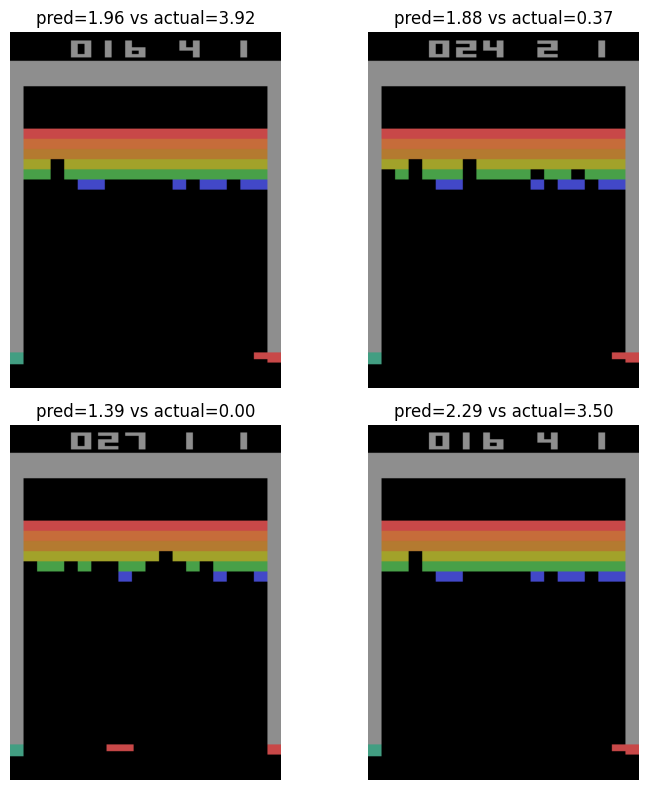

ball low (b): 0.9299999999999999


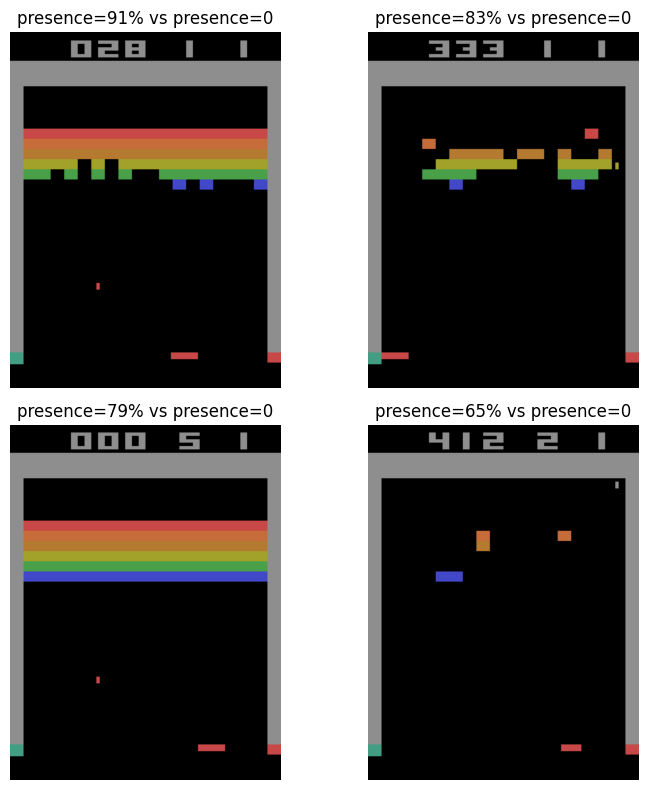

ball collision (b): 0.72


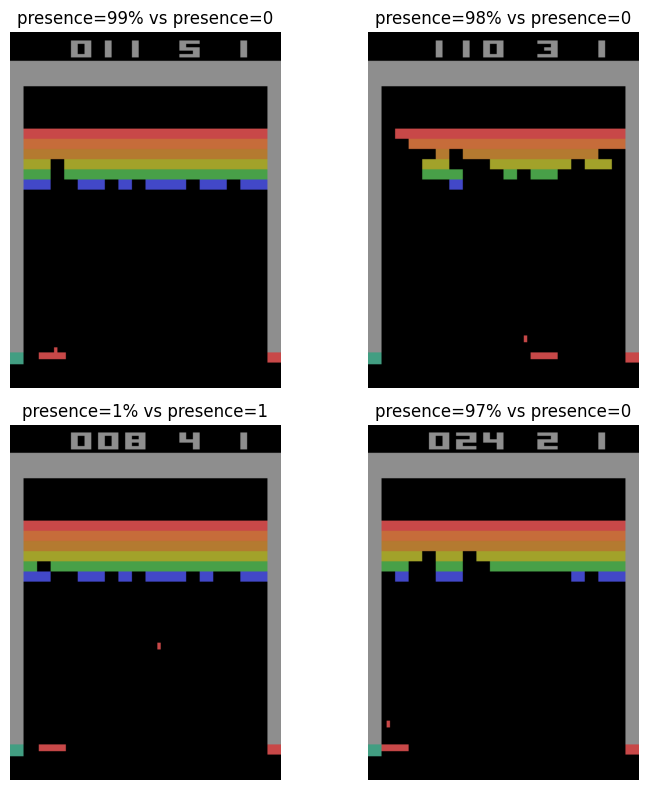

ball going right (b): 0.6200000000000001


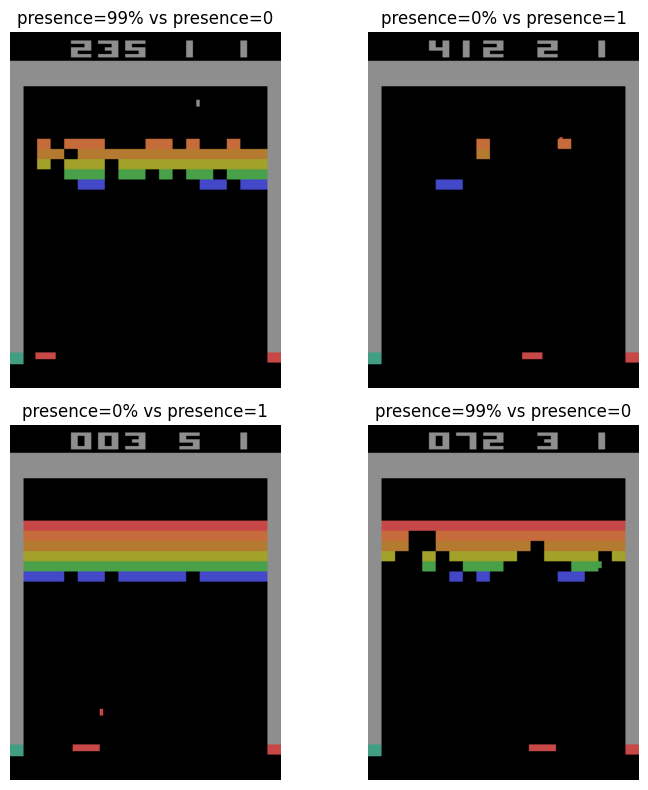

ball going left (b): 0.6399999999999999


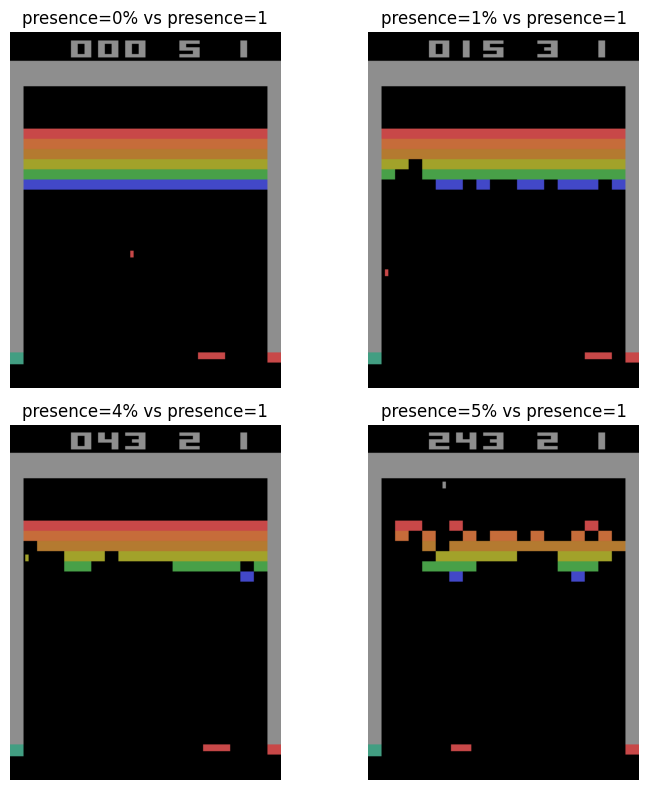

ball going up (b): 0.77


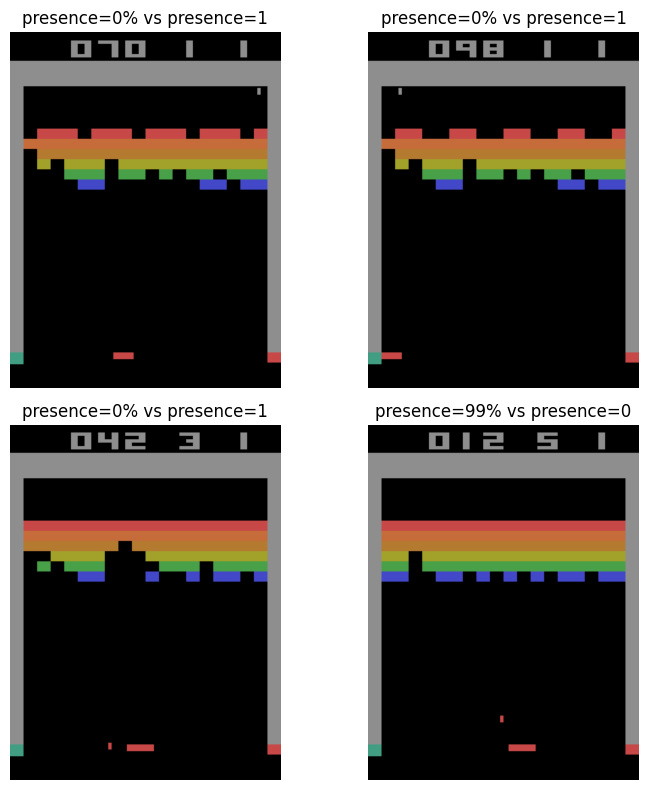

ball going down (b): 0.8200000000000001


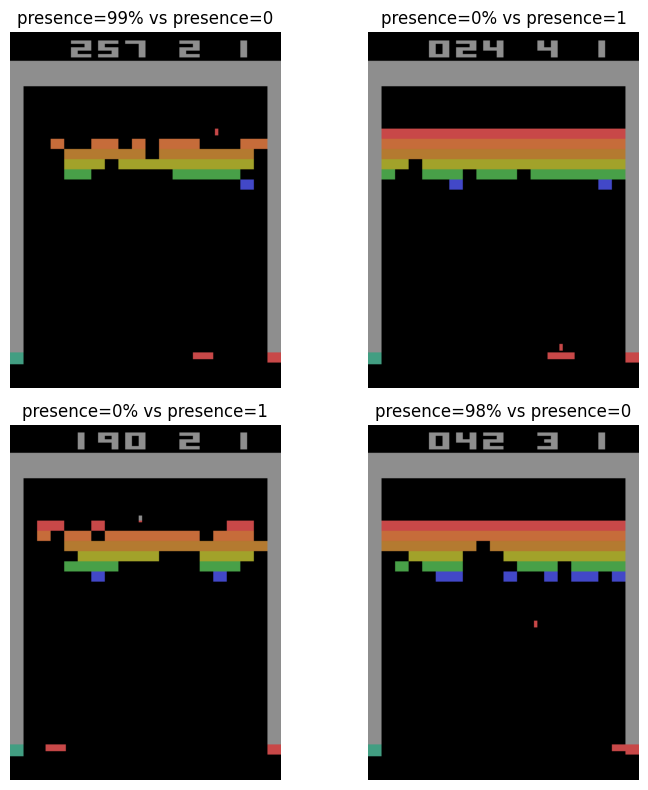

ball speed: 0.3012966658743893


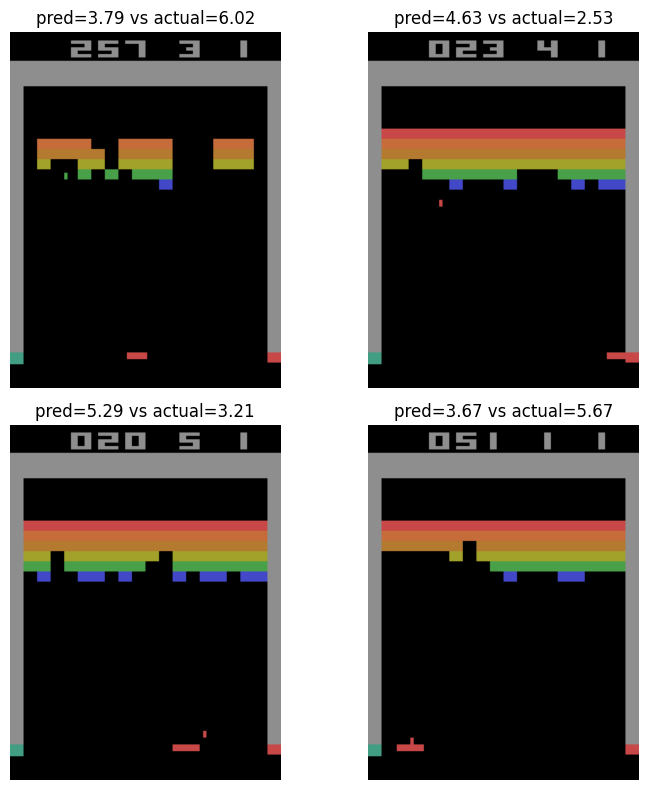

paddle x: 0.9638777555008438


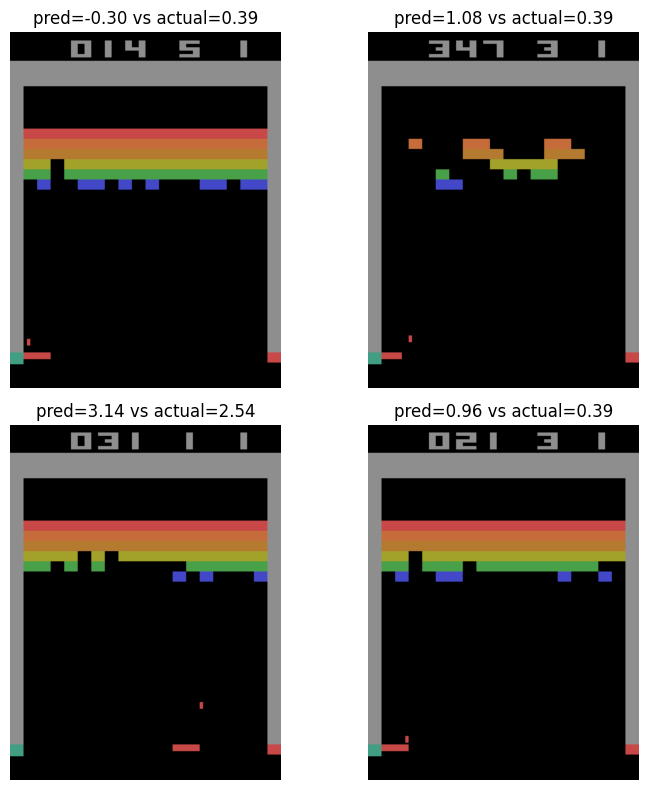

ball left for paddle (b): 0.71


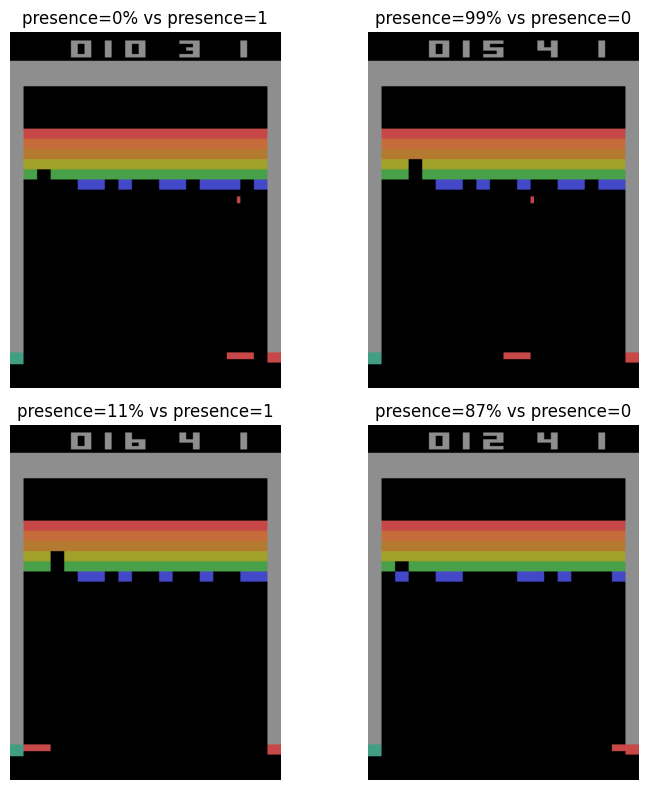

ball right for paddle (b): 0.6599999999999999


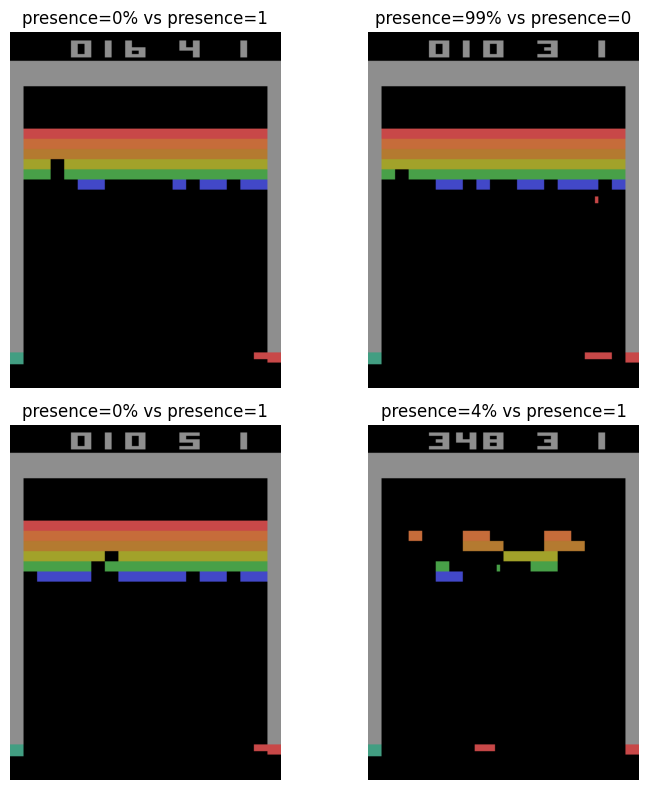

ball above paddle (b): 0.6000000000000001


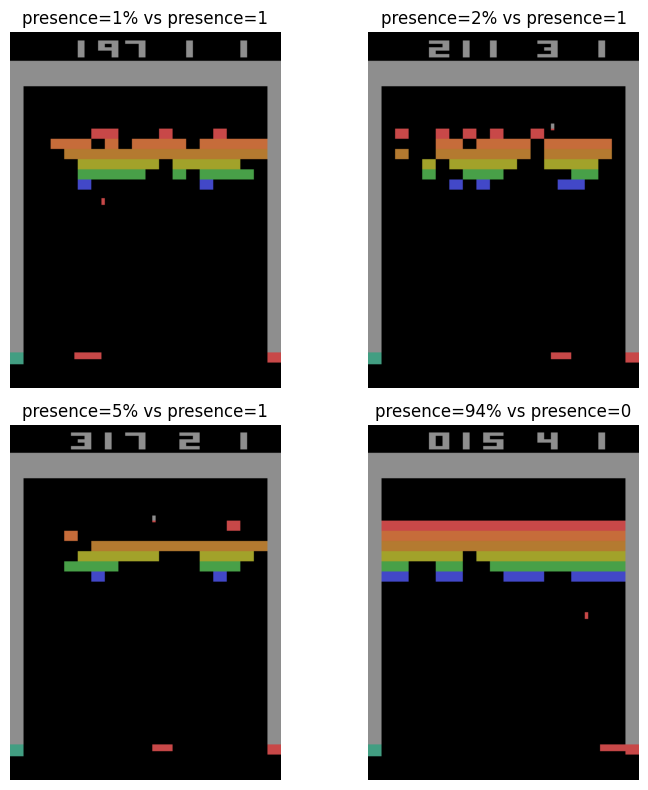

ball paddle distance: -4.633055725195465


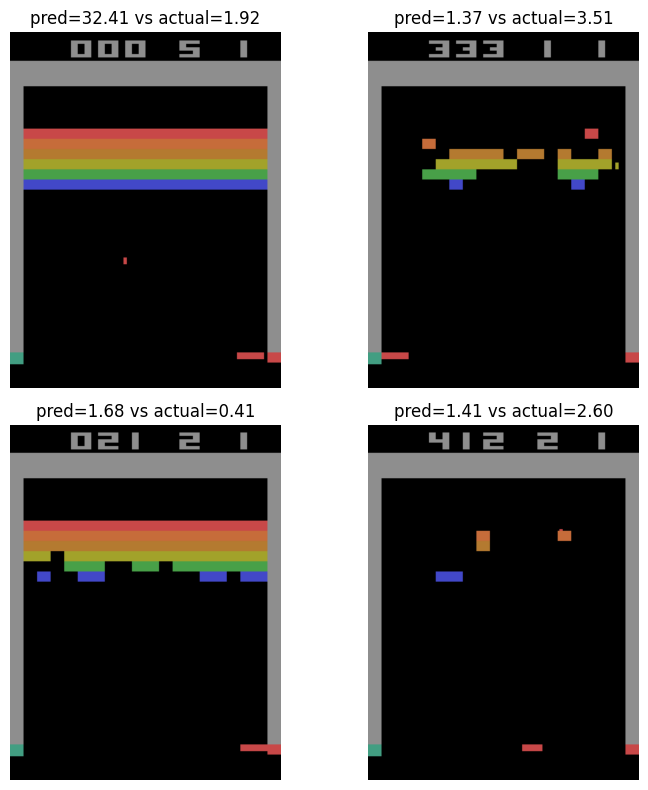

lives: 0.9781188872527155


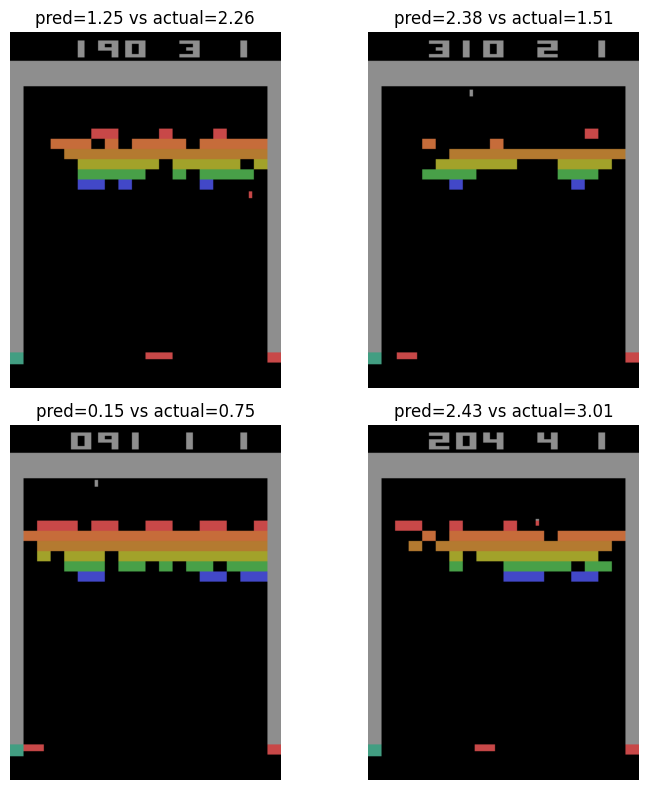

last life (b): 0.99


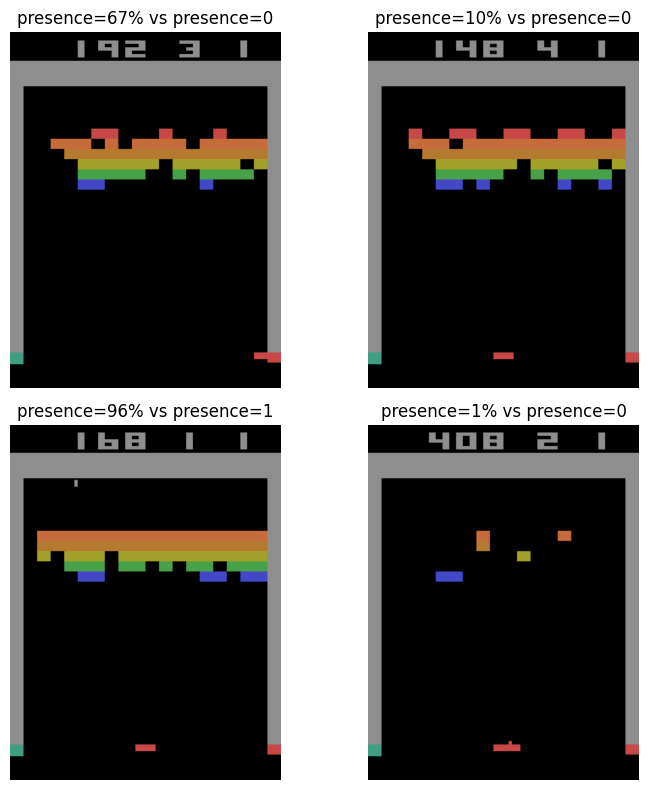

losing life (b): 0.956043956043956


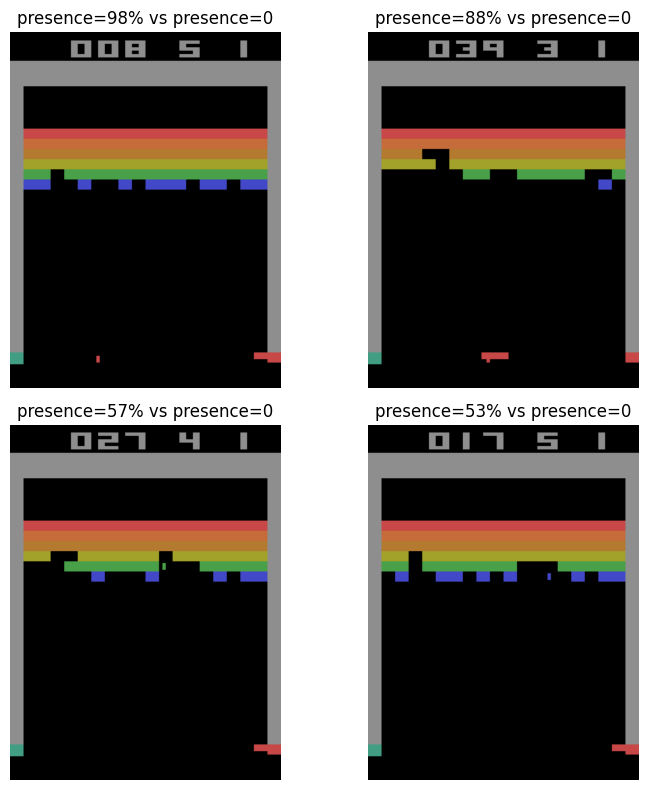

random (b): -0.020000000000000018


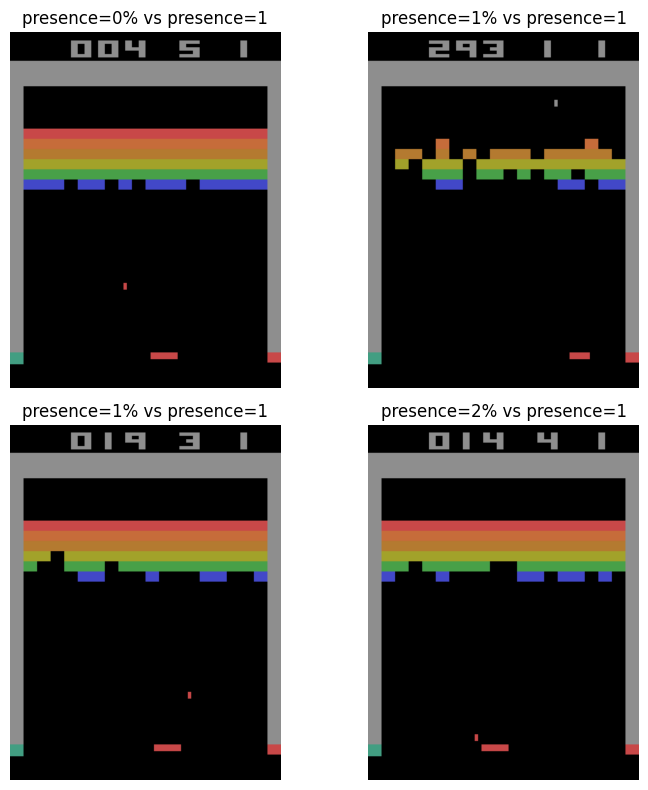

brick hit (b): 0.9099999999999999


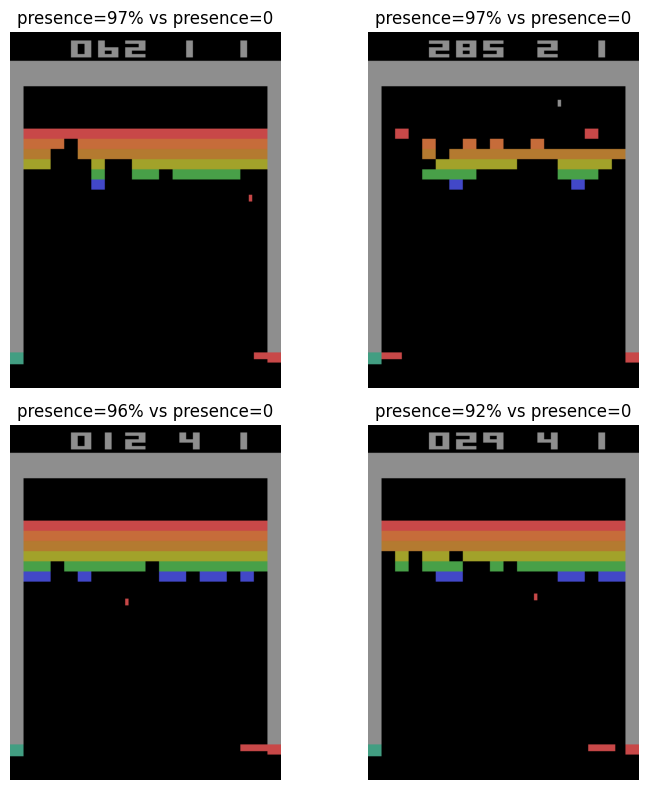

bricks hit: 0.9799927096513029


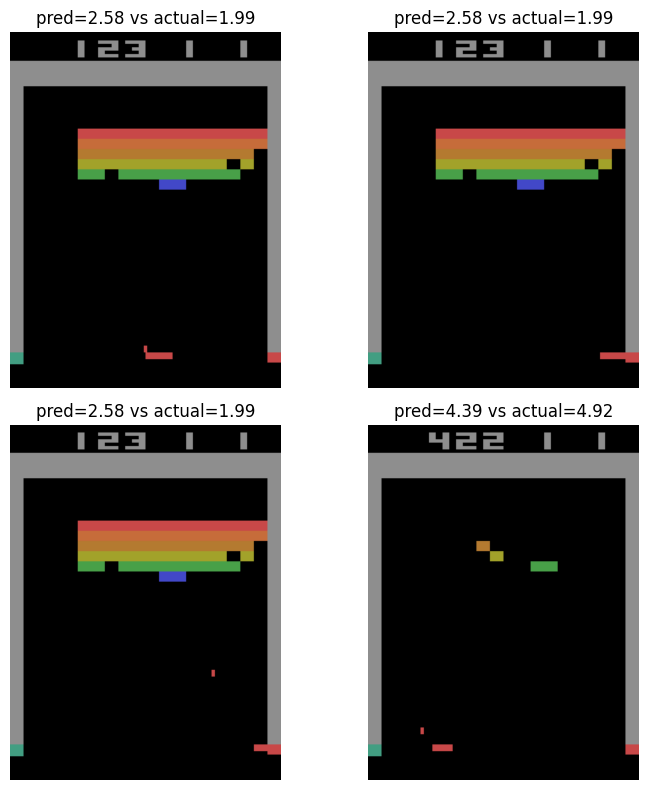

In [5]:
q_network, device = load_q_network_device()
for concept in concept_instances.values():
    concept.prepare_data(game_data, max_size=max_data_size)
    _, train_acts_dict = q_network(torch.tensor(concept.train_obs).to(device), return_acts=True)
    _, test_acts_dict = q_network(torch.tensor(concept.test_obs).to(device), return_acts=True)
    train_values = concept.train_values
    test_values = concept.test_values

    train_acts = train_acts_dict[str(layer)].cpu().detach().numpy()
    test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
    train_acts = train_acts.reshape(len(train_acts), -1)
    test_acts = test_acts.reshape(len(test_acts), -1)

    if concept.binary:
        reg, score = train_binary(train_acts, train_values, test_acts, test_values, max_iter, k_fold, num_reg)
    else:
        reg, score = train_non_binary(train_acts, train_values, test_acts, test_values, max_iter, k_fold, num_reg)
    print(f'{concept.name}: {score}')

    # Calculate residuals and sort them to find the worst predictions
    if concept.binary:
        proba = reg.predict_proba(test_acts)
        residuals = np.abs(proba[:, 1] - test_values)
    else:
        residuals = np.abs(reg.predict(test_acts) - test_values)

    num_images = 4
    worst = residuals.argsort()[-num_images:][::-1]
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()  # Flatten the 2D array of axes to iterate over them

    for idx, ax in zip(worst, axes):
        ax.imshow(concept.test_images[idx])
        if concept.binary:
            ax.set_title(f'presence={int(proba[idx, 1]*100)}% vs presence={test_values[idx]}')
        else:
            pred = reg.predict(test_acts[idx].reshape(1, -1))[0]
            ax.set_title(f'pred={pred:.2f} vs actual={test_values[idx]:.2f}')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'../figures/residuals/{concept.name}.png', bbox_inches='tight')
    plt.show()